# Problema - 3

J0 si J1 dau cu banul pentru a decide cine incepe

1. se arunca cu propriul zar, fie n numarul obtinut
2. se arunca de 2*n ori cu propria moneda, fie m numarul de steme obtinut

if n > m castiga 1 else 2

J1 probability pentru stema = 4/7 -> 3/7 pentru cap

In [134]:
import random

def simulate_round(starter_coin, opponent_coin):
    n = random.randint(1, 6)
    m = 0

    for _ in range(0, 2*n + 1):
        coinFlip = random.choices([0, 1], weights=opponent_coin, k=1)[0]
        if coinFlip == 0: m += 1

    return n >= m

normal_coin = [3/7, 5/7]
biased_coin = [1/2, 1/2]

num_simulations = 10000
j0_wins = 0
j1_wins = 0


for _ in range(num_simulations):
    who_starts = random.randint(0, 1)
    
    if who_starts == 0: 
        if simulate_round(normal_coin, biased_coin):
            j0_wins += 1
        else:
            j1_wins += 1
    else:
        if simulate_round(biased_coin, normal_coin):
            j1_wins += 1
        else:
            j0_wins += 1
            

print(f"J0 wins: {j0_wins} ({j0_wins / num_simulations:.2%})")
print(f"J1 wins: {j1_wins} ({j1_wins / num_simulations:.2%})")

J0 wins: 3704 (37.04%)
J1 wins: 6296 (62.96%)


J0 are D0 si S0
J1 are D1 si S1

C -> cine incepe jocul
P(C=j0) = 1/2
P(C=j1) = 1/2

n = 1,2,3,4,5,6
P(D0=n) = 1/6 
P(D1=n) = 1/6

J0 incepe.
P(stema)=4/7
S0∼Binomial(2D0,4/7).

J1 incepe.
P(stema)=1/2
S1∼Binomial(2D1,1/2)

J0 castiga daca D0 >= S0
J1 castiga daca D0 < S0

J1 castiga daca D1 >= S1
J0 castiga daca D1 < S1

In [104]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

model = BayesianNetwork([
    ('C', 'Y'),
    ('Y', 'D0'),
    ('Y', 'D1'),
    ('D0', 'S0'),
    ('D1', 'S1'),
    ('D0', 'W'),
    ('S0', 'W'),
    ('D1', 'W'),
    ('S1', 'W')
])

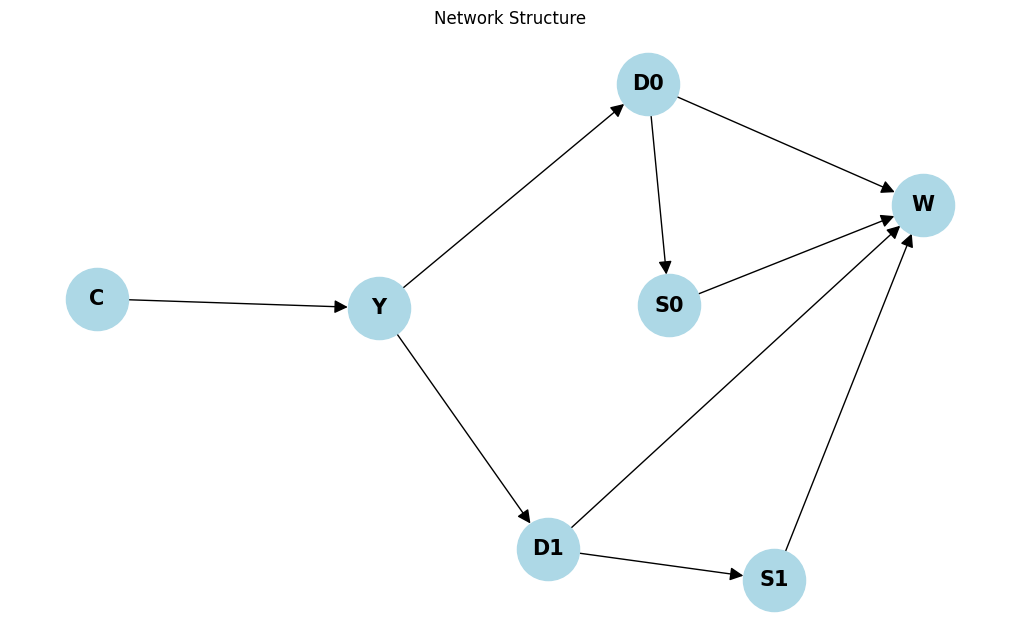

In [115]:
import matplotlib.pyplot as plt
import networkx as nx

graph = nx.DiGraph()
graph.add_edges_from(model.edges())

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(graph) 
nx.draw(graph, pos, with_labels=True, arrows=True, node_size=2000, node_color='lightblue', font_size=15, font_weight='bold', arrowsize=20)

plt.title('Network Structure')
plt.show()

In [117]:
cpd_C = TabularCPD(variable='C', variable_card=2, values=[[0.5], [0.5]])

cpd_Y = TabularCPD(variable='Y', variable_card=2, evidence=['C'], evidence_card=[2], values=[
                    [1, 0], 
                    [0, 1]
                ])

cpd_D0 = TabularCPD(variable='D0', variable_card=6, evidence=['Y'], evidence_card=[2], values=[
                    [1/6, 1/6],
                    [1/6, 1/6],
                    [1/6, 1/6],
                    [1/6, 1/6],
                    [1/6, 1/6],
                    [1/6, 1/6],
                ])

cpd_D1 = TabularCPD(variable='D1', variable_card=6, evidence=['Y'], evidence_card=[2], values=[
                    [1/6, 1/6],
                    [1/6, 1/6],
                    [1/6, 1/6],
                    [1/6, 1/6],
                    [1/6, 1/6],
                    [1/6, 1/6],
                ])

In [118]:
p_S0 = 4 / 7  # Probabilitatea de a obține o stemă pentru J1
p_S1 = 1 / 2  # Probabilitatea de a obține o stemă pentru J0

d0_values = range(1, 7)  # D0
d1_values = range(1, 7)  # D1

In [120]:
from scipy.stats import binom
import numpy as np

cpd_S0 = []
for d0 in d0_values:
    probabilities = [binom.pmf(k, 2 * d0, p_S0) for k in range(2 * d0 + 1)]
    extended_probabilities = np.zeros(13)
    extended_probabilities[:len(probabilities)] = probabilities

    cpd_S0.append(extended_probabilities)

cpd_S0_array = np.array(cpd_S0).T

cpd_S0 = TabularCPD(variable='S0', variable_card=2 * 6 + 1, 
                            evidence=['D0'], evidence_card=[6], 
                            values=cpd_S0_array)

cpd_S1 = []
for d1 in d1_values:
    probabilities = [binom.pmf(k, 2 * d1, p_S1) for k in range(2 * d1 + 1)]
    extended_probabilities = np.zeros(13)
    extended_probabilities[:len(probabilities)] = probabilities
    
    cpd_S1.append(extended_probabilities)

cpd_S1_array = np.array(cpd_S1).T

cpd_S1 = TabularCPD(variable='S1', variable_card=2 * 6 + 1, 
                            evidence=['D1'], evidence_card=[6], 
                            values=cpd_S1_array)

In [122]:
max_S0 = 2 * 6  # maximul steme obținute de J1
max_S1 = 2 * 6  # maximul steme obținute de J0

# Definirea CPD-ului pentru W
cpd_W = np.zeros((2, len(d0_values), len(d1_values), max_S0 + 1, max_S1 + 1))  # 2 pentru J0 și J1

for i, d0 in enumerate(d0_values):
    for j, d1 in enumerate(d1_values):
        for s0 in range(max_S0 + 1):
            for s1 in range(max_S1 + 1):
                # Probabilitatea ca J0 să câștige
                if d0 >= s1:
                    cpd_W[0][i][j][s0][s1] = 1  # J0 câștigă
                else:
                    cpd_W[1][i][j][s0][s1] = 1  # J1 câștigă

# Reshape pentru a transforma în formatul necesar pentru TabularCPD
cpd_W_reshaped = cpd_W.reshape(2, -1)  # Reshape pentru a obține formatul dorit

# Crearea CPD-ului pentru W
cpd_W = TabularCPD(variable='W', variable_card=2, 
                    evidence=['D0', 'D1', 'S0', 'S1'], 
                    evidence_card=[6, 6, max_S0 + 1, max_S1 + 1], 
                    values=cpd_W_reshaped)

In [124]:
model.add_cpds(cpd_C, cpd_Y, cpd_D0, cpd_D1, cpd_S0, cpd_S1, cpd_W)
model.check_model()
infer = VariableElimination(model)

In [133]:
prob_j0_wins = infer.query(variables=['W'])
print(prob_j0_wins)

+------+----------+
| W    |   phi(W) |
+======+==========+
| W(0) |   0.5841 |
+------+----------+
| W(1) |   0.4159 |
+------+----------+
